###  Logistic Regression

Logistic regression predicts the probability of the outcome being true. In this exercise, we will implement logistic regression and apply it to two different datasets. 

The data is from the famous Machine Learning Coursera Course by Andrew Ng. The lab exercises in that course are in Octave/Matlab. I am planning to do all the programming exercises in that course with R. So far, I have done [linear](http://datascience-enthusiast.com/R/Linear_Regression.html) regression and [anomaly detecion](http://datascience-enthusiast.com/R/anomaly_detection_R.html).

The file  <a href="ex1data1.txt">ex2data1.txt</a> contains the dataset for the first part of the exercise and <a href="ex1data1.txt">ex2data2.txt</a> is data that we will use in the second part of the exercise.

In the first part of this exercise, we will build a logistic regression model to
predict whether a student gets admitted into a university. Suppose that you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant's scores on two exams and the admissions decision.

Our task is to build a classification model that estimates an applicant's probability of admission based the scores from those two exams.

In [41]:
library(ggplot2)
library(data.table)
library(magrittr)
library(caret)
library(optimx)

#### Load the data and display first 6 observations

  The first two columns contains the exam scores and the third column contains the label.

In [42]:
ex2data1 <- fread("ex2data1.txt",col.names=c("Exam1","Exam2","Label"))    
head(ex2data1) 

Exam1,Exam2,Label
34.62366,78.02469,0
30.28671,43.89500,0
35.84741,72.90220,0
60.18260,86.30855,1
79.03274,75.34438,1
45.08328,56.31637,0


####  Visualizing the data

Before starting to implement any learning algorithm, it is always good to visualize the data if possible.

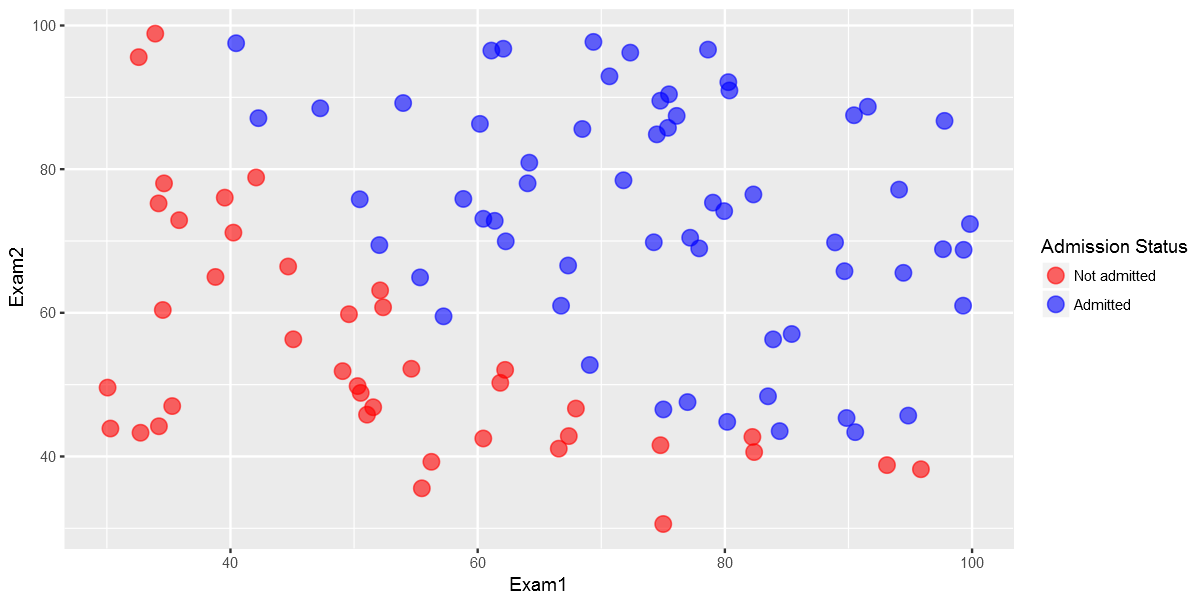

In [43]:
cols <- c("0" = "red","1" = "blue")
ex2data1%>%ggplot(aes(x=Exam1,y=Exam2,color=factor(Label)))+geom_point(size = 4, shape = 19,alpha=0.6)+
scale_colour_manual(values = cols,labels = c("Not admitted", "Admitted"),name="Admission Status")

Logistic Regression hypothesis is defined as:

$$h_\theta(x)=g(\theta^Tx)$$ where function g is the sigmoid function, which is defined as below:
$$g(z)=\frac{1}{1+e^{-z}}$$

Let's code the sigmoid function so that we can call it in the rest of our programs.

In [14]:
my_sigmoid=function(z){
    1/(1+exp(-z))
}

For large positive values of x, the sigmoid should be close to 1, while for large negative values,
the sigmoid should be close to 0. Evaluating sigmoid(0) should give exactly 0.5.

Let's check!

In [10]:
my_sigmoid(0)

[1] 0.5

In [11]:
my_sigmoid(10^10)

[1] 1

In [12]:
my_sigmoid(-10^10)

[1] 0

We can visualize the sigmoid function graphycally:

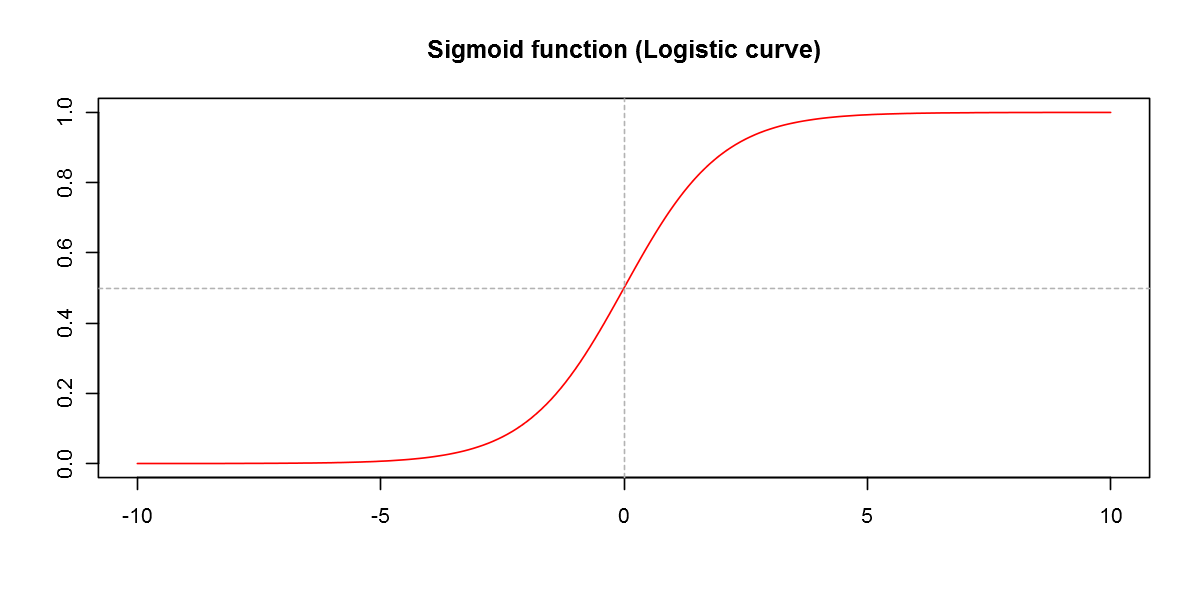

In [13]:
x=seq(-10,10, by=0.1)
y=my_sigmoid(x)

plot(x,y,type="l",col="red",xlab="",ylab="",main="Sigmoid function (Logistic curve)")
abline(v=0,lty = 2,col="gray 70")
abline(h=0.5,lty = 2,col="gray70")

### Cost function and gradient

The cost function in logistic regression is given by:


$$ J(\theta)=\frac{1}{m}\sum\limits_{i=1}^{m}[-y^{(i)}log(h_\theta(x^{(i)}))-(1-y^{(i)})log(1-h_\theta(x^{(i)}))] $$
    

and the gradient of the cost is a vector of the same length as $\theta$ where the $j^{th}$ element (for j = 0, 1, ..., n) is defined as follows:

$$\frac{\partial J(\theta)}{\partial \theta_j}  = \frac{1}{m}\sum\limits_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)} $$

Note that while this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $h_\theta(x)$.

Add ones for the intercept term:

In [14]:
y=ex2data1$Label
X=cbind(1,ex2data1$Exam1,ex2data1$Exam2)
head(X)

1,34.62366,78.02469
1,30.28671,43.89500
1,35.84741,72.90220
1,60.18260,86.30855
1,79.03274,75.34438
1,45.08328,56.31637


Initialize fitting parameters:

In [15]:
initial_theta =matrix(rep(0,ncol(X)))

The function below calculates cost.

In [16]:
my_cost=function(theta, X, y){
    cost_gradient=list()
    # cost_and_gradient compute cost and gradient for logistic regression using theta
    h_theta= my_sigmoid(X%*%theta)
    cost= 1/nrow(X)*sum(-y*log(h_theta)-(1-y)*log(1-h_theta))
    return(cost)
}

What is the cost for the initial theta parameters, which are all zeros?

In [17]:
round(my_cost(initial_theta, X, y),3)

[1] 0.693

The function below calculates gradient.

In [18]:
my_gradient=function(theta, X, y){
    
    h_theta= my_sigmoid(X%*%theta)
    
    ## OPTION 1-- looping
    
    #    gradient=rep(0,ncol(X))
    #      for(j in 1:ncol(X)){
    #       for(i in 1:nrow(X)){
    #    gradient[j]=gradient[j]+1/nrow(X)*(my_sigmoid(X[i,]%*%theta)-y[i])*X[i,j]
    #                   }
    #               }
    
    # option2-more succint
   gradient= 1/nrow(X)*(my_sigmoid(t(theta)%*%t(X))-t(y))%*%X
    return(gradient)                                                                           
}

The gradient for the initial theta parameters, which are all zeros, is shown below

In [19]:
round(my_gradient(initial_theta, X, y),3)

-0.1,-12.009,-11.263


#### General-purpose Optimization in lieu of Gradient Descent

We can use gradient descent to get the optimal theta values but using optimazation libraries converges quicker. So, let's use the **optim** general-purpose Optimization in R to get the required theta values and the associated cost.

In [20]:
optimized=optim(par=initial_theta,X=X,y=y,fn=my_cost,gr=my_gradient)

In [21]:
names(optimized)

[1] "par"         "value"       "counts"      "convergence" "message"

In [22]:
cat("The optimized theta values are: ")
round(optimized$par,3)

The optimized theta values are: 

-25.165
0.206
0.202


In [23]:
cat('The cost at the final theta values is: ')
round(optimized$value,3)

The cost at the final theta values is: 

[1] 0.203

#### Decision Boundary

Now, let's plot the decision bounday
Only 2 points are required to define a line, so let's choose two endpoints.

In [24]:
plot_x = c(min(ex2data1$Exam1)-2,max(ex2data1$Exam1)+2)

# Calculate the decision boundary line
plot_y = (-1/optimized$par[3])*(optimized$par[2]*plot_x+optimized$par[1])

## Calculate slope and intercept
slope =(plot_y[2]-plot_y[1])/(plot_x[2]-plot_x[1])
intercept=plot_y[2]-slope*plot_x[2]

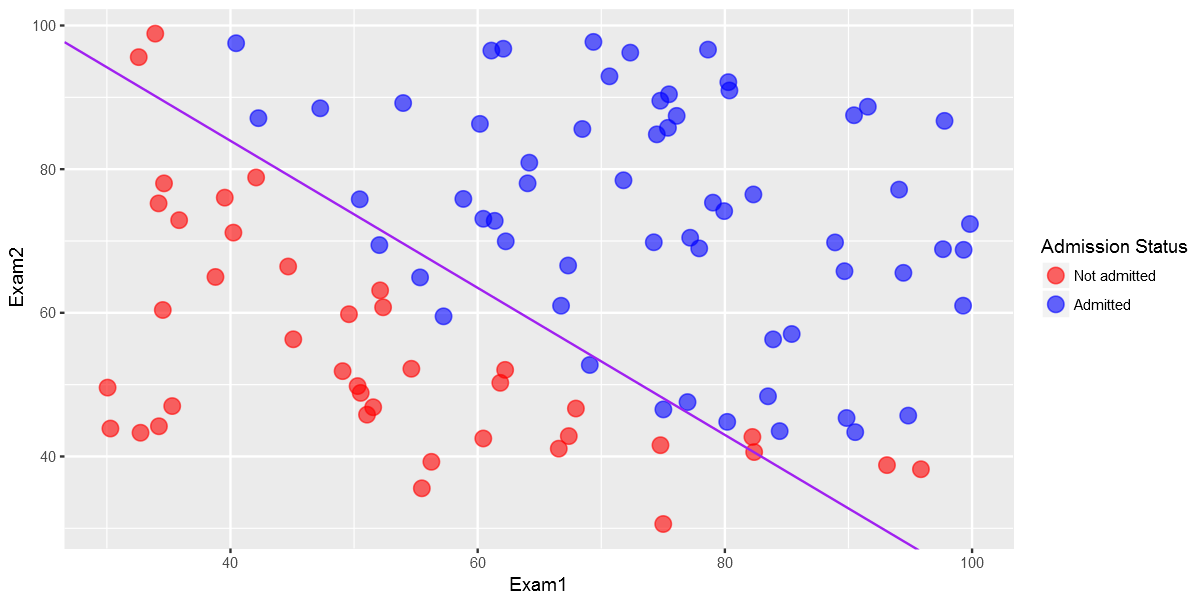

In [25]:
cols <- c("0" = "red","1" = "blue")
ex2data1%>%ggplot(aes(x=Exam1,y=Exam2,color=factor(Label)))+geom_point(size = 4, shape = 19,alpha=0.6)+
scale_colour_manual(values = cols,labels = c("Not admitted", "Admitted"),name="Admission Status")+
geom_abline(intercept = intercept, slope = slope,col="purple",show.legend=TRUE)

#### Evaluating logistic regression

After learning the parameters, you can use the model to predict whether a particular student will be admitted. For example, for a student with an Exam 1 score of 45 and an Exam 2 score of 85, the probability of admission is shown below.

In [26]:
round(my_sigmoid(c(1,45,85)%*%optimized$par),3)

0.776


###### Model accuracy

Now, let's calculate the model accuracy. Let's use a threshould of 0.5.

In [27]:
ex2data1$fitted_result=my_sigmoid(X%*%optimized$par)
ex2data1$fitted_result_label=ifelse(ex2data1$fitted_result>=0.5,1,0)
head(ex2data1)

Exam1,Exam2,Label,fitted_result,fitted_result_label
34.62366,78.02469,0,9.102720e-02,0
30.28671,43.89500,0,4.220398e-05,0
35.84741,72.90220,0,4.389943e-02,0
60.18260,86.30855,1,9.904316e-01,1
79.03274,75.34438,1,9.982001e-01,1
45.08328,56.31637,0,1.079133e-02,0


In [28]:
accuracy=sum(ex2data1$Label==ex2data1$fitted_result_label)/(nrow(ex2data1))
accuracy

[1] 0.89

#### Regularized logistic regression

In this part of the exercise, we will implement regularized logistic regression to predict whether microchips from a fabrication plant pass quality assurance (QA). During QA, each microchip goes through various tests to ensure
it is functioning correctly.
Suppose you are the product manager of the factory and you have the test results for some microchips on two diffeerent tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected.

#### Visualizing the data

In [3]:
ex2data2 <- fread("ex2data2.txt",col.names=c("Test1","Test2","Label"))    
head(ex2data2) 

Test1,Test2,Label
0.051267,0.69956,1
-0.092742,0.68494,1
-0.213710,0.69225,1
-0.375000,0.50219,1
-0.513250,0.46564,1
-0.524770,0.20980,1


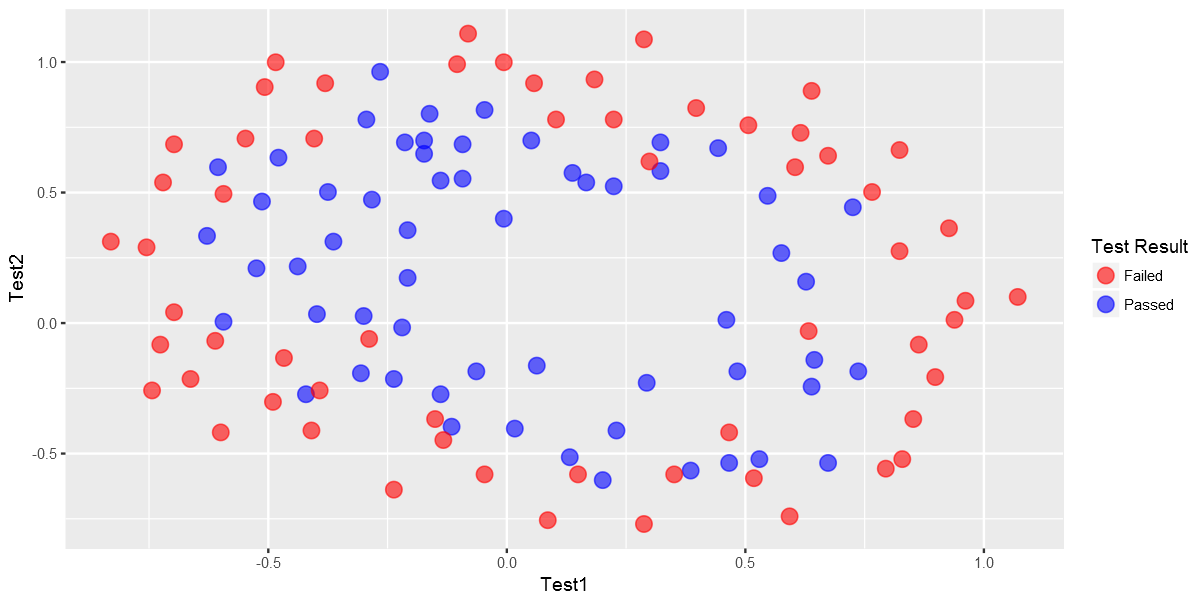

In [6]:
cols <- c("0" = "red","1" = "blue")
ex2data2%>%ggplot(aes(x=Test1,y=Test2,color=factor(Label)))+geom_point(size = 4, shape = 19,alpha=0.6)+
scale_colour_manual(values = cols,labels = c("Failed", "Passed"),name="Test Result")

The above figure shows that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straightforward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

#### Feature mapping

One way to fit the data better is to create more features from each data point. Let's map the features into
all polynomial terms of x1 and x2 up to the sixth power.

In [7]:
new_data=c()

for(i in 1:6){
    for(j in 0:i){
        temp= (ex2data2$Test1)^i+(ex2data2$Test2)^(i-j)
        new_data=cbind(new_data,temp)
    }
}
    
colnames(new_data)=paste0("V",1:ncol(new_data))

In [8]:
head(new_data)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27
0.750827,1.051267,0.4920125,0.7021883,1.002628,0.34248835,0.48951894,0.69969475,1.0001347,0.23950380,...,0.489384548,0.6995604,1.0000004,0.11720601,0.16754246,0.23949691,0.34235362,0.48938421,0.6995600,1.000000
0.592198,0.907258,0.4777439,0.6935411,1.008601,0.32053699,0.46834512,0.68414232,0.9992023,0.22016895,...,0.469135943,0.6849331,0.9999931,0.10325661,0.15075249,0.22009561,0.32133531,0.46914344,0.6849406,1.000001
0.478540,0.786290,0.5248820,0.7379220,1.045672,0.32197261,0.46944951,0.68248944,0.9902394,0.23172821,...,0.478764279,0.6918042,0.9995542,0.11014216,0.15906514,0.22973755,0.33182843,0.47930533,0.6923453,1.000095
0.127190,0.625000,0.3928198,0.6428150,1.140625,0.07391533,0.19946042,0.44945563,0.9472656,0.08337761,...,0.244779025,0.4947742,0.9925842,0.01882106,0.03472131,0.06638313,0.12943062,0.25497571,0.5049709,1.002781
-0.047610,0.486750,0.4802462,0.7290656,1.263426,-0.03424282,0.08161744,0.33043683,0.8647968,0.11640420,...,0.181204639,0.4300240,0.9643840,0.02847289,0.04017018,0.06529107,0.11924025,0.23510051,0.4839199,1.018280
-0.314970,0.475230,0.3193996,0.4851836,1.275384,-0.13527846,-0.10049699,0.06528697,0.8554870,0.07777351,...,0.004219529,0.1700035,0.9602035,0.02096929,0.02129048,0.02282143,0.03011858,0.06490005,0.2306840,1.020884


In [9]:
y=ex2data2$Label
X=new_data

As a result of this mapping, our vector of two features (the scores on
two QA tests) has been transformed into a 28-dimensional vector. A logistic
regression classier trained on this higher-dimension feature vector will have
a more complex decision boundary and will appear nonlinear when drawn in
our 2-dimensional plot.
While the feature mapping allows us to build a more expressive classifier,
it also more susceptible to overfitting. In the next parts of the exercise, we
will implement regularized logistic regression to fit the data and also see for
ourselves how regularization can help combat the overfitting problem.

In [10]:
my_cost2=function(theta, X, y,lambda){
    cost_gradient=list()
    # cost_and_gradient compute cost and gradient for logistic regression using theta
    h_theta= my_sigmoid(X%*%theta)
    cost= 1/nrow(X)*sum(-y*log(h_theta)-(1-y)*log(1-h_theta))+lambda/(2*nrow(X))*sum(theta^2)
    return(cost)
}

In [11]:
my_gradient2=function(theta, X, y,lambda){
    
    h_theta= my_sigmoid(X%*%theta)
    
    ## OPTION 1-- looping
    
       gradient=rep(0,ncol(X))
    
      for(j in 2:ncol(X)){
        for(i in 1:nrow(X)){
        gradient[1]=gradient[1]+1/nrow(X)*(my_sigmoid(X[i,]%*%theta)-y[i])*X[i,1]
        gradient[j]=gradient[j]+1/nrow(X)*(my_sigmoid(X[i,]%*%theta)-y[i])*X[i,j]+lambda/(nrow(X))*theta[j]
                       }
                   }
    
    # option2-more succint
  # gradient= 1/nrow(X)*(my_sigmoid(t(theta)%*%t(X))-t(y))%*%X+(lambda/(nrow(X)))*c(0,theta[-1])
    return(gradient)                                                                           
}

Let's initialize theta:

In [12]:
initial_theta =matrix(rep(0,ncol(X)))

What is the cost for the initial theta?

In [15]:
round(my_cost2(initial_theta,X,y,lambda=10),3)

[1] 0.693

#####  Optimization

Now, since we have the cost function that we want to optimize and the gradient, we can use the optimization function **optim** to find the optimal theta values.

We have to try various values of lambda and select the best lambda based on cross-validation. But for now, let's just take  lambda=10.

In [25]:
optimized=optim(par=initial_theta,X=X,y=y,lambda=1,fn=my_cost2,gr=my_gradient2,method="BFGS")

In [ ]:
optimized=(par=initial_theta,X=X,y=y,lambda=1,fn=my_cost2,gr=my_gradient2,method="BFGS")

The theta values from the optimization are shown below.

In [26]:
matrix(as.vector(optimized$par),ncol=9)

0.49507083,-0.05202124,-0.08527443,-0.1575100,-0.035020544,-0.11079198,0.01169745,-0.12174228,-0.12234383
0.05639364,-0.02062364,0.01959276,-0.1129876,-0.003622936,-0.06626957,0.04309506,-0.13996607,-0.01747664
-0.15688844,-0.05837426,0.05099037,-0.1398877,-0.092568188,-0.09316975,-0.14349836,-0.09544366,0.01392097


In [27]:
ex2data2$fitted_result=my_sigmoid(X%*%optimized$par)

In [28]:
head(ex2data2)

Test1,Test2,Label,fitted_result,fitted_result_label
0.051267,0.69956,1,0.4765027,0
-0.092742,0.68494,1,0.4629791,0
-0.213710,0.69225,1,0.4410811,0
-0.375000,0.50219,1,0.4701446,0
-0.513250,0.46564,1,0.4459059,0
-0.524770,0.20980,1,0.4554844,0


Let's use a threshould of 0.5.

In [29]:
ex2data2$fitted_result_label=ifelse(ex2data2$fitted_result>=0.5,1,0)
head(ex2data2,10)

Test1,Test2,Label,fitted_result,fitted_result_label
0.051267,0.699560,1,0.4765027,0
-0.092742,0.684940,1,0.4629791,0
-0.213710,0.692250,1,0.4410811,0
-0.375000,0.502190,1,0.4701446,0
-0.513250,0.465640,1,0.4459059,0
-0.524770,0.209800,1,0.4554844,0
-0.398040,0.034357,1,0.4730207,0
-0.305880,-0.192250,1,0.4618593,0
0.016705,-0.404240,1,0.4735035,0
0.131910,-0.513890,1,0.4640032,0


### Evaluating the fit

Let's calculate `F1 score`, which uses `precision` and `recall`. `Precision` and `rcall` in turn are calculated using `true positive`, `false positive` and `false negative` as defined below. We will also see the model accuracy.

**tp** is the number of true positives: the ground truth label says it's an
anomaly and our algorithm correctly classied it as an anomaly.

 **fp** is the number of false positives: the ground truth label says it's not
an anomaly, but our algorithm incorrectly classied it as an anomaly.

 **fn** is the number of false negatives: the ground truth label says it's an
anomaly, but our algorithm incorrectly classied it as not being anoma-
lous.


The F1 score is computed using precision (prec) and recall (rec):

$$prec = \frac{tp}{tp+fp}$$

$$rec = \frac{tp}{tp+fn}$$

$$F1 = 2.\frac{prec.rec}{prec+rec}$$

In [30]:
tp=sum((ex2data2$Label==1)&(ex2data2$fitted_result_label==1))
fp=sum((ex2data2$Label==0)&(ex2data2$fitted_result_label==1))
prec=tp/(tp+fp)
cat("The precision is:")
round(prec,3)

The precision is:

[1] 0.793

In [31]:
tp=sum((ex2data2$Label==1)&(ex2data2$fitted_result_label==1))
fn=sum((ex2data2$Label==1)&(ex2data2$fitted_result_label==0))
rec=tp/(tp+fn)
cat("The recall is:")
round(rec,3)

The recall is:

[1] 0.397

In [32]:
F1=2*(prec*rec)/(prec+rec)
cat("The F1 score is:")
round(F1,3)

The F1 score is:

[1] 0.529

In [33]:
accuracy=sum(ex2data2$Label==ex2data2$fitted_result_label)/nrow(ex2data2)

cat("The accuracy is: ")
round(accuracy,3)

The accuracy is: 

[1] 0.653

#### Summary

Logistic regression is a classification machine learning technique. In this blog post, we saw how to implement logistic regression with and without regularization. In the first part, we used it to predict if a student will be admitted to a university and in the second part, we used it to predict whether microchips from a fabrication plant pass quality assurance. We used special optimization function in lieu of gradient descent to get the optimal values of the coeffients.